## Table of Contents
- [Setup](#setup)
    - [Imports](#imports)
    - [Data loading](#data-loading)
- [Data splitting](#data-splitting)
- [Feature selection and model selection](#feature-selection-and-model-selection)
    - [Features](#features)
    - [Models](#models)
- [Feature refinement](#feature-refinement)
- [Model evaluation](#model-evaluation)
- [Final model performance](#final-model-performance)

![Code Flow Diagram](images/Fig2.jpg)

# Setup

### Imports

In [10]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from atom import ATOMClassifier
import csv
import json
from sklearn.metrics import roc_auc_score, auc, roc_curve, accuracy_score, precision_score, recall_score
import matplotlib.pyplot as plt
from scipy import interp

### Data loading

In [ ]:
X = pd.read_csv("path/to/data_ab.csv", index_col = 0)

In [83]:
X.shape

(94, 1156549)

# Data splitting
- X has 94 samples.
- We will first split to Train (76 samples) and Test (18 samples) sets.
- Then we will further split the Train set to Subtrain(67) and Validation(9) sets.

In [ ]:
random_state = 123

# Perform stratified train/test split
train_val, test = train_test_split(X, test_size=18, stratify=X['y'], random_state=random_state)

# Feature selection and model selection
We will split the Training set to Subtrain and Validation 100 times. We will analyze the results of 100 splits.

In [ ]:
# Split the Training set (76 samples) to Subtrain(67) and Validation(9) sets
# and select top 600 features from Subtrain

def split_train_val(train_val, x):
    # Perform stratified train/val split
    train, val = train_test_split(train_val, test_size=9, stratify=train_val['y'], random_state=x)
    
    # Drop the target column 'y' from the training set for feature selection
    train_features = train.drop(columns=['y'])

    # Calculate the number of non-zero values for each feature
    non_zero_counts = (train_features != 0).sum(axis=0)

    # Select the top 600 features with the most non-zero values
    top_600_features = non_zero_counts.nlargest(600).index

    # Select these top 600 features from the training set
    train_top_features = train_features.loc[:, top_600_features]

    # Add the target column back to the training set with selected features
    train_top_features['y'] = train['y']

    # Select these top 600 features from the val set
    val_top_features = val.loc[:, top_600_features]

    # Add the target column back to the validation set with selected features
    val_top_features['y'] = val['y']

    return train_top_features, val_top_features


# Create a classifier, perform feature selection and train 8 models.
def create_atom(train, test, split):
    atom = ATOMClassifier(train, test, y="y", verbose=2, warnings=False, random_state = 1, index=True)

    solvers = ["LR", "XGB"]
    models = ["GBM", "LR", "LDA", "QDA", "RNN", "AdaB", "RF", "XGB"] 

    for solver in solvers:
        atom.branch = "sfm" + solver + "_from_master"
        atom.feature_selection(strategy="SFM", solver=solver, n_features=10, random_state=0)
    
        models_named = [model + "_" + solver for model in models]
        atom.run(models=models_named, n_calls=50, n_initial_points=10, metric="AUC", n_bootstrap=5)

    return atom


In [ ]:
features_dict = {}
models_dict = {}
results_dict = {}

with open('features.csv', mode='w', newline='') as file:
    writer = csv.writer(file)
    header = ['Iteration'] + [f'Feature_{i}' for i in range(10)]
    writer.writerow(header)

    # 100 iterations
    for i in range(1,101):
        # Split train_val into train and val
        train, val = split_train_val(train_val, i)
        # Create classifier
        atom = create_atom(train, val, i)
        
        features_list = atom.winner.features
        features_dict[i] = features_list
        row = [i] + features_list
        writer.writerow(row)

        models_dict[i] = atom.winner.name
        results_dict[i] = atom.winner.mean_bootstrap


with open('features_dict.json', 'w') as file:
    json.dump(features_dict, file)

with open('models_dict.json', 'w') as file:
    json.dump(models_dict, file)

with open('results_dict.json', 'w') as file:
    json.dump(results_dict, file)

### Features
- Summarize results from 100 splits

In [ ]:
# Filter rows from features.csv which were trained with one of the three most popular models 
features_df = pd.read_csv("/features.csv", index_col = 0)
filtered_res_df = res_df[res_df['model'].isin(['AdaB_LR','GBM_LR', 'XGB_LR'])].sort_values(by='auc', ascending=False)
filtered_res_df['Iteration'] = pd.to_numeric(filtered_res_df['Iteration'])
selected_iterations = filtered_res_df['Iteration'].values
filtered_features_df = features_df[features_df.index.isin(selected_iterations)]
filtered_features_df

,Feature_0,Feature_1,Feature_2,Feature_3,Feature_4,Feature_5,Feature_6,Feature_7,Feature_8,Feature_9
Iteration,,,,,,,,,,
10,CVVSDRGSTLGRLYF,CAVRDNYGQNFVF,CALSAARSSNTGKLIF,CADHQNYGGSQGNLIF,CAVEETSGSRLTF,CALQGGSEKLVF,CAATDSWGKLQF,CAGHDYKLSF,CAATQGGSEKLVF,CAALYNFNKFYF
13,CVVSDRGSTLGRLYF,CAVRDSNYQLIW,CALSAARSSNTGKLIF,CADHQNYGGSQGNLIF,CAVEETSGSRLTF,CAATDSWGKLQF,CALQGGSEKLVF,CAASEYGNKLVF,CAGHDYKLSF,CAATQGGSEKLVF
14,CVVSDRGSTLGRLYF,CAVRDSNYQLIW,CALSAARSSNTGKLIF,CAVRDNYGQNFVF,CADHQNYGGSQGNLIF,CAAGGTSYGKLTF,CALQGGSEKLVF,CAGHDYKLSF,CAATQGGSEKLVF,CAASEYGNKLVF
15,CVVSDRGSTLGRLYF,CAVRDSNYQLIW,CALSAARSSNTGKLIF,CADHQNYGGSQGNLIF,CAVEETSGSRLTF,CAATDSWGKLQF,CALQGGSEKLVF,CAASEYGNKLVF,CAGHDYKLSF,CAATQGGSEKLVF
19,CVVSDRGSTLGRLYF,CAVMDSSYKLIF,CAVRDNYGQNFVF,CADHQNYGGSQGNLIF,CAVEETSGSRLTF,CAATDSWGKLQF,CALQGGSEKLVF,CAASEYGNKLVF,CAGHDYKLSF,CAATQGGSEKLVF
20,CAVRDSNYQLIW,CALSAARSSNTGKLIF,CADHQNYGGSQGNLIF,CAVRDNYGQNFVF,CAAGGTSYGKLTF,CAVEETSGSRLTF,CAATDSWGKLQF,CALQGGSEKLVF,CAGHDYKLSF,CAATQGGSEKLVF
21,CVVSDRGSTLGRLYF,CAVMDSSYKLIF,CALSAARSSNTGKLIF,CADHQNYGGSQGNLIF,CAVEETSGSRLTF,CALQGGSEKLVF,CAATDSWGKLQF,CAGHDYKLSF,CAALYNFNKFYF,CAATQGGSEKLVF
24,CVVSDRGSTLGRLYF,CALSAARSSNTGKLIF,CADHQNYGGSQGNLIF,CAAGGTSYGKLTF,CAVEETSGSRLTF,CALQGGSEKLVF,CAATDSWGKLQF,CAASEYGNKLVF,CAGHDYKLSF,CAALYNFNKFYF
25,CAVRDSNYQLIW,CALSAARSSNTGKLIF,CADHQNYGGSQGNLIF,CASASPSSYNEQFF,CAAGGTSYGKLTF,CAVEETSGSRLTF,CALQGGSEKLVF,CAGHDYKLSF,CAATQGGSEKLVF,CAALYNFNKFYF


In [ ]:
# Flatten the df 
flattened_values = filtered_features_df.values.flatten()

# Count the occurrences of each unique value
value_counts = pd.Series(flattened_values).value_counts()

# Convert to a df for easier viewing
value_counts_df = value_counts.reset_index()
value_counts_df.columns = ['Feature', 'Count']

value_counts_df

,Feature,Count
0,CADHQNYGGSQGNLIF,44
1,CALQGGSEKLVF,44
2,CAGHDYKLSF,44
3,CALSAARSSNTGKLIF,41
4,CVVSDRGSTLGRLYF,38
5,CAATDSWGKLQF,37
6,CAVEETSGSRLTF,35
7,CAASEYGNKLVF,34
8,CAVRDSNYQLIW,33
9,CAALYNFNKFYF,27


Only 16 unique features were repeatedly chosen.

In [17]:
features16 = value_counts_df['Feature'].tolist()
features16

['CADHQNYGGSQGNLIF',
 'CALQGGSEKLVF',
 'CAGHDYKLSF',
 'CALSAARSSNTGKLIF',
 'CVVSDRGSTLGRLYF',
 'CAATDSWGKLQF',
 'CAVEETSGSRLTF',
 'CAASEYGNKLVF',
 'CAVRDSNYQLIW',
 'CAALYNFNKFYF',
 'CAATQGGSEKLVF',
 'CAAGGTSYGKLTF',
 'CAVRDNYGQNFVF',
 'CAVMDSSYKLIF',
 'CASASPSSYNEQFF',
 'CAVDNTDKLIF']

### Models

In [ ]:
with open('models_dict.json', 'r') as file:
    models_dict = json.load(file)

with open('results_dict.json', 'r') as file:
    results_dict = json.load(file)

res_df = pd.DataFrame({
    'Iteration': models_dict.keys(),
    'model': models_dict.values(),
    'auc': results_dict.values() # mean_bootstrap
})

In [ ]:
# Which models were chosen as winners?
res_df['model'].value_counts()

AdaB_LR     17
GBM_LR      15
XGB_LR      12
RF_LR       10
GBM_XGB      7
QDA_LR       6
RF_XGB       6
LR_LR        6
RNN_XGB      5
RNN_LR       5
AdaB_XGB     5
LDA_LR       3
XGB_XGB      2
QDA_XGB      1
Name: model, dtype: int64

The top 3 popular models are all boosting models, and they were chosen in 44 out of 100 splits.

# Feature refinement
- We will split the Training set to Subtrain and Validation 10 times. 
- We will use the 16 features found in the previous step. We will refine further to 10 features. 
- We will use a boosting model as found most promising in the previous step.

In [ ]:
# Split Train to Subtrain and Val and select features from a given list
def split_train_val_select(train_val, x, features):
    # Perform stratified train/val split
    train, val = train_test_split(train_val, test_size=9, stratify=train_val['y'], random_state=x)

    # Select the given features from the training set
    train_fs = train.loc[:, features + ['y']]

    # Select the given features from the val set
    val_fs = val.loc[:, features + ['y']]

    return train_fs, val_fs


# Create atom and perform feature selection using LR and train with XGB
def create_atom_fs(train, test, split):
    atom = ATOMClassifier(train, test, y="y", verbose=2, warnings=False, random_state = 1, index=True)
    solver = "LR"
    models = ["XGB"]
    atom.feature_selection(strategy="SFM", solver=solver, n_features=10, random_state=0)
    atom.run(models=models, n_calls=50, n_initial_points=10, metric="AUC", n_bootstrap=5)
    return atom



In [ ]:
# 10 splits of the Training set to Subtrain and Validation
# This time using 16 selected features
# Narrowing down to 10 with SFM, solver: LR
# Model: XGB

results_dict_fs_test = {}
features10 = []

for i in range(200,210):
    train, val = split_train_val_select(train_val, i, features16)
    atom = create_atom_fs(train, val, i)
    selected_features = atom.features
    features10.append(selected_features)
    results_dict_fs_test[i] = atom.winner.metric_test   #mean_bootstrap

with open('results_dict_XGB_fs10_test.json', 'w') as file:
    json.dump(results_dict_fs_test, file)

with open('features10.json', 'w') as file:
    json.dump(features10, file)

In [9]:
with open('features10.json', 'r') as file:
    features10 = json.load(file)

features10_df = pd.DataFrame(features10)
features10_df

,0,1,2,3,4,5,6,7,8,9
0,CADHQNYGGSQGNLIF,CALQGGSEKLVF,CAGHDYKLSF,CALSAARSSNTGKLIF,CAATDSWGKLQF,CAVEETSGSRLTF,CAVRDSNYQLIW,CAALYNFNKFYF,CAVRDNYGQNFVF,CAVMDSSYKLIF
1,CADHQNYGGSQGNLIF,CALQGGSEKLVF,CAGHDYKLSF,CALSAARSSNTGKLIF,CVVSDRGSTLGRLYF,CAATDSWGKLQF,CAVEETSGSRLTF,CAASEYGNKLVF,CAALYNFNKFYF,CAATQGGSEKLVF
2,CADHQNYGGSQGNLIF,CALQGGSEKLVF,CAGHDYKLSF,CVVSDRGSTLGRLYF,CAATDSWGKLQF,CAVEETSGSRLTF,CAASEYGNKLVF,CAVRDSNYQLIW,CAALYNFNKFYF,CAATQGGSEKLVF
3,CADHQNYGGSQGNLIF,CALQGGSEKLVF,CAGHDYKLSF,CALSAARSSNTGKLIF,CVVSDRGSTLGRLYF,CAATDSWGKLQF,CAVEETSGSRLTF,CAASEYGNKLVF,CAVRDSNYQLIW,CAATQGGSEKLVF
4,CADHQNYGGSQGNLIF,CALQGGSEKLVF,CALSAARSSNTGKLIF,CAATDSWGKLQF,CAVEETSGSRLTF,CAASEYGNKLVF,CAALYNFNKFYF,CAATQGGSEKLVF,CAVRDNYGQNFVF,CAVMDSSYKLIF
5,CALQGGSEKLVF,CAGHDYKLSF,CVVSDRGSTLGRLYF,CAATDSWGKLQF,CAVEETSGSRLTF,CAASEYGNKLVF,CAVRDSNYQLIW,CAALYNFNKFYF,CAATQGGSEKLVF,CAVRDNYGQNFVF
6,CADHQNYGGSQGNLIF,CALQGGSEKLVF,CAGHDYKLSF,CALSAARSSNTGKLIF,CVVSDRGSTLGRLYF,CAVEETSGSRLTF,CAASEYGNKLVF,CAALYNFNKFYF,CAVRDNYGQNFVF,CAVMDSSYKLIF
7,CADHQNYGGSQGNLIF,CALQGGSEKLVF,CAGHDYKLSF,CALSAARSSNTGKLIF,CVVSDRGSTLGRLYF,CAATDSWGKLQF,CAVEETSGSRLTF,CAASEYGNKLVF,CAVRDSNYQLIW,CAATQGGSEKLVF
8,CADHQNYGGSQGNLIF,CALQGGSEKLVF,CAGHDYKLSF,CALSAARSSNTGKLIF,CAATDSWGKLQF,CAVEETSGSRLTF,CAASEYGNKLVF,CAVRDSNYQLIW,CAALYNFNKFYF,CAATQGGSEKLVF
9,CADHQNYGGSQGNLIF,CALQGGSEKLVF,CAGHDYKLSF,CALSAARSSNTGKLIF,CVVSDRGSTLGRLYF,CAATDSWGKLQF,CAVEETSGSRLTF,CAASEYGNKLVF,CAALYNFNKFYF,CAATQGGSEKLVF


In [12]:
features10_df.to_csv('features10_df.csv' )

# Model evaluation
- For each of the 10 feature sets, we will train the model on the entire train set.
- We will evaluate the model on 4 different subsamplings of the test set.
- This comes to show that the results are independant of the subsampling.

In [ ]:
# Create a classifier from each feature set and train on full train set

atom10 = []

for i,fset in enumerate(features10):

    full_train_fs = train_val.loc[:, fset + ['y']]
    test_fs = test.loc[:, fset + ['y']]
    atom = ATOMClassifier(full_train_fs, test_fs, y="y", verbose=2, warnings=False, random_state = 1, index=True)
    models = ["XGB"]
    atom.run(models=models, n_calls=50, n_initial_points=10, metric="AUC", n_bootstrap=5)
    atom10.append(atom)

In [ ]:
# Subsampling was performed in R
subsampled_data = []
sub_paths = ["sub1_all_ab.csv", "sub2_all_ab.csv", "sub3_all_ab.csv", "sub4_all_ab.csv"]
for path in sub_paths:
    full_path = "/mult_subsampls/" + path
    X_sub = pd.read_csv(full_path, index_col = 0)
    subsampled_data.append(X_sub)
    print(path + " added")

sub1_all_ab.csv added
sub2_all_ab.csv added
sub3_all_ab.csv added
sub4_all_ab.csv added


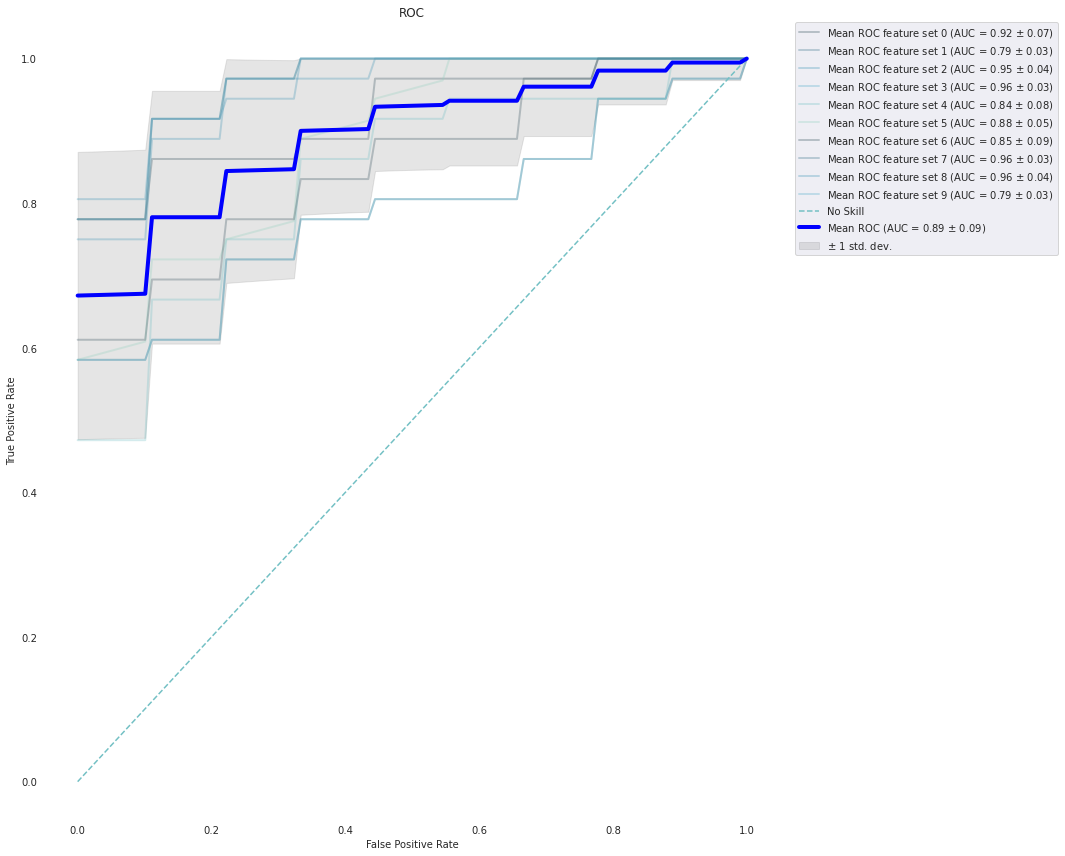

In [ ]:
# For each classifier, check on 4 different subsamplings of the test set

test_indices = test.index.tolist() # 18 samples

fig = plt.figure(figsize=[20,12])
ax = fig.add_subplot(111)

tprs = []
aucs = []
mean_fpr = np.linspace(0,1,100)

# For each classifier
for i,atom in enumerate(atom10):
    test_features = atom.features
    tprs_fset = []
    aucs_fset = []
    mean_fpr_fset = np.linspace(0,1,100)
    # For each subsampling
    for id, X_sub in enumerate(subsampled_data):    
        X_test = X_sub.loc[test_indices, test_features]
        y_test = [0 if row_name.endswith('H') else 1 for row_name in X_test.index]
        
        yhat = atom.winner.predict_proba(X_test)[:, 1]
        fpr, tpr, thresholds = roc_curve(y_test, yhat)
        roc_auc = auc(fpr, tpr)
        tprs_fset.append(interp(mean_fpr, fpr, tpr)) 
        aucs_fset.append(roc_auc)

        tprs.append(interp(mean_fpr, fpr, tpr)) 
        aucs.append(roc_auc)
    
    mean_tpr_fset = np.mean(tprs_fset, axis=0)
    mean_auc_fset = auc(mean_fpr_fset, mean_tpr_fset)
    std_auc_fset = np.std(aucs_fset)
    plt.plot(mean_fpr_fset, mean_tpr_fset, lw=2, alpha=0.3, label=r'Mean ROC feature set %d (AUC = %0.2f $\pm$ %0.2f)' % (i, mean_auc_fset, std_auc_fset))


plt.plot([0,1], [0,1], linestyle='--', label='No Skill')

mean_tpr = np.mean(tprs, axis=0)
mean_auc = auc(mean_fpr, mean_tpr)
std_auc = np.std(aucs)
plt.plot(mean_fpr, mean_tpr, lw=4, alpha=1, color='blue', label=r'Mean ROC (AUC = %0.2f $\pm$ %0.2f)' % (mean_auc, std_auc))

std_tpr = np.std(tprs, axis=0)
tprs_lower = mean_tpr - std_tpr
tprs_upper = np.minimum(mean_tpr + std_tpr, 1)
ax.fill_between(mean_fpr, tprs_lower, tprs_upper, color="grey", alpha=0.2, label=r"$\pm$ 1 std. dev.",)

ax.set_xlabel('False Positive Rate')
ax.set_ylabel('True Positive Rate')
ax.set_title('ROC')
ax.legend(bbox_to_anchor=(1.02, 1), loc='upper left', borderaxespad=0.)
plt.tight_layout(rect=[0, 0, 0.75, 1])
ax.set_facecolor('w')
name = "roc_all_avg.pdf"
plt.savefig(name, transparent= True)


In [ ]:
avg_recall = []
avg_spec = []
avg_prec = []
avg_auc = []
avg_acc = []

for i,atom in enumerate(atom10):
    test_indices = atom.y_test.index.to_list()
    fset = atom.features

    recall_values = []
    specificity_values = []
    precision_values = []
    auc_values = []
    acc_values = []

    for id, X_sub in enumerate(subsampled_data): 
        
        X_test = X_sub.loc[test_indices, fset]
        y_test = [0 if row_name.endswith('H') else 1 for row_name in X_test.index]
        
        yhat = atom.winner.predict_proba(X_test)[:, 1]
        y_pred = (yhat > 0.5).astype('float')

        auc = roc_auc_score(atom.y_test, yhat)
        auc_values.append(auc)
        acc = accuracy_score(atom.y_test, y_pred)
        acc_values.append(acc)
        precision = precision_score(atom.y_test, y_pred)
        precision_values.append(precision)
        recall = recall_score(atom.y_test, y_pred) #sensitivity
        recall_values.append(recall)
        specificity = recall_score(atom.y_test, y_pred, pos_label=0)
        specificity_values.append(specificity)

    mean_recall = np.mean(recall_values)
    mean_specificity = np.mean(specificity_values)
    mean_precision = np.mean(precision_values)
    mean_auc = np.mean(auc_values)
    mean_acc = np.mean(acc_values)

    avg_recall.append(mean_recall)
    avg_spec.append(mean_specificity)
    avg_prec.append(mean_precision)
    avg_auc.append(mean_auc)
    avg_acc.append(mean_acc)

performance_all = pd.DataFrame({
    'avg_auc': avg_auc,
    'avg_accuracy': avg_acc,
    'avg_recall': avg_recall,
    'avg_specificity': avg_spec,
    'avg_precision': avg_prec,  
})

performance_all.to_csv("performance_all.csv")


In [ ]:
# Add Validation col
performance_all["auc_validation"] = results_dict_fs_test.values()

performance_all = performance_all.reset_index().rename(columns={'index': 'feature_set'})
# Reorder 
columns = ['feature_set', 'auc_validation'] + [col for col in performance_all.columns if col != 'auc_validation' and col != 'feature_set']
performance_all = performance_all[columns]
performance_all

,feature_set,auc_validation,avg_auc,avg_accuracy,avg_recall,avg_specificity,avg_precision
0,0,0.85,0.922840,0.805556,0.972222,0.638889,0.732517
1,1,1.00,0.787037,0.736111,0.555556,0.916667,0.886905
2,2,1.00,0.932099,0.847222,0.833333,0.861111,0.857639
3,3,0.85,0.962963,0.875000,0.972222,0.777778,0.818813
4,4,1.00,0.833333,0.736111,0.611111,0.861111,0.824405
5,5,0.95,0.882716,0.750000,0.916667,0.583333,0.689423
6,6,0.90,0.851852,0.722222,0.555556,0.888889,0.842857
7,7,1.00,0.962963,0.875000,0.972222,0.777778,0.818813
8,8,0.95,0.962963,0.833333,0.944444,0.722222,0.779895
9,9,1.00,0.787037,0.736111,0.555556,0.916667,0.886905


In [98]:
performance_all.to_csv("performance_and_val.csv")

# Final model performance

The model created from feature set #7 achieved an AUC of 1.0 on the Validation set and an average AUC of 0.96 across multiple subsamplings of the Test set. 

In [ ]:
atom_winner = atom10[7]
atom_winner.winner.metric_test
atom_winner.save("atom_BC_10f_winner", save_data=True)

ATOMClassifier successfully saved.


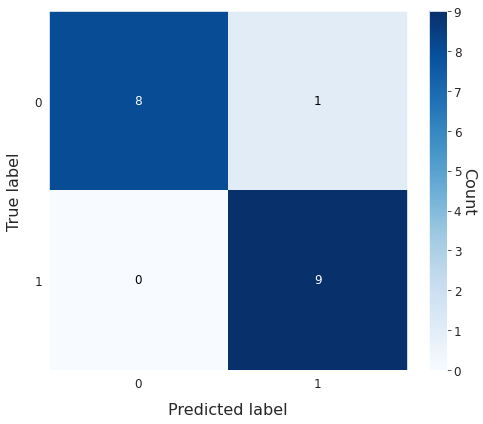

In [ ]:
atom_winner.winner.plot_confusion_matrix(filename = "atom_winner_cm_test.pdf")

In [ ]:
atom_winner.features

['CADHQNYGGSQGNLIF',
 'CALQGGSEKLVF',
 'CAGHDYKLSF',
 'CALSAARSSNTGKLIF',
 'CVVSDRGSTLGRLYF',
 'CAATDSWGKLQF',
 'CAVEETSGSRLTF',
 'CAASEYGNKLVF',
 'CAVRDSNYQLIW',
 'CAATQGGSEKLVF']

In [ ]:
import time
start_time = time.time()
atom_winner.winner.predict_proba_test
end_time = time.time()

elapsed_time = end_time - start_time
print(f"Elapsed time: {elapsed_time} seconds")

Elapsed time: 0.0002598762512207031 seconds


In [ ]:
atom_winner.winner.best_params

{'n_estimators': 385,
 'learning_rate': 0.0101,
 'max_depth': 5,
 'gamma': 1.0,
 'min_child_weight': 1,
 'subsample': 0.9,
 'colsample_bytree': 0.5,
 'reg_alpha': 0,
 'reg_lambda': 0}